In [52]:
from numba import jit, njit
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import kwant.kpm


import scipy

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

import cmath

from qutip import *
from joblib import Parallel, delayed


In [53]:
def corr_dis(L, W, a, xic):
    Nx = int(L/a)
    Ny = int(W/a)
    Vxy = np.random.normal(0, 1., size=(Ny, Nx))/(a) + 1j*0.0
    
    kkVxy = np.fft.fft2(Vxy)
    kx = 2*np.pi * np.fft.fftfreq(kkVxy.shape[1],d=a)
    ky = 2*np.pi * np.fft.fftfreq(kkVxy.shape[0],d=a)
    kx, ky = np.meshgrid(kx,ky)
    
    kVxy = np.multiply(kkVxy, np.exp( - .125 * xic**2. * (kx**2.+ky**2.)  ) ) * xic/np.sqrt(2.)
    
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)

    return Vxy

In [54]:
def v_img_singleside(W, N, min_l):
    arr_x = np.linspace(min_l, W+min_l, N)
    arr_V = - 1./(np.abs( arr_x ))
    return arr_V

def v_expcutoff_img_singleside(W, N, min_l, xiV):
    arr_x = np.linspace(min_l, W+min_l, N)
    arr_V = - 1./(np.abs( arr_x ))*np.exp( -(arr_x-min_l)**2/(2*xiV**2) )
    #arr_V = - 1./(np.abs( arr_x )) /( np.exp( (arr_x-min_l - xiV)/(.01*xiV) ) + 1 )
    return arr_V

In [55]:
lat = kwant.lattice.square(a=1, norbs=1)
Ncore = 6       #number of cores used in the calculation
iter_dis = 4

t = 1   # hopping rate for kwant
L = 80  # spatial width of the system ( Nx )
W = 80  # spatial length of the system ( Ny )


nG = 0

# Energy-Length-Magnetic scale (arbitrary) just to have a dimensional reference for the parameters
#a=0.6 # real lattice spacing in GaAs, in nm
#BandW0 = 40   #total bandwidth in meV
#l0 = np.sqrt(568/BandW0*8.) * 10**(-3.) # effective lattice spacing sqrt( \hbar^2/(2m*)/(\hbar J)) here I took \hbar^2/(2m*) = 568 nm^2 meV (GaAs) and \hbar J = BW/8 in micron!
#B0 = 4.14*10**3. / (l0 * 10**3.)**2. #in T, as 2\pi \hbar/e 1/a^2

# Adimensional magnetic flux
alpha = 1/40
lB = 1./np.sqrt(2*np.pi*alpha)
omB = 4*np.pi*alpha

xic = lB * 1      # Correlation length and definition of disorder-potential array
Vdis = corr_dis(int(L), int(W), 1, xic)

plate_distance = (20+nG)*lB      #edge-plate distance

#Vimg = np.linspace(0, W-1, W)/lB
#E_img = omB * .4         #Image charge amplitude in cyclotrons
Vimg0 = v_img_singleside(W, int(W), plate_distance)   # normalized image potential single plate
Vimg1 = v_expcutoff_img_singleside(W, int(W), plate_distance, 20*lB)
Vimg = Vimg0
V_img_min = np.amin(Vimg)
Vimg = Vimg - V_img_min / 1.25
E_img = omB*lB * ( (plate_distance/lB)**2 )/2. * .4         # Image charge amplitude in cyclotrons
E_dis = omB * (.00000 )                   # disorder amplitude in cyclotrons


# Definitions for Kwant
def onsite(site, params):
    xi, yi = site.pos
    
    om0 = + 4 * t
    omRan = params.E_dis*params.V[int(yi)][int(xi)]
    omImg = params.E_img * Vimg[int(yi)] 
    
    return  om0 + omRan + omImg

def hopping(site_i, site_j, params):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return - t*np.exp(-1j * 2*np.pi * params.alpha * (xi - xj) * (yi + yj)/2.)

def onsite_lead(site, params):
    xi, yi = site.pos
    return  4 * t

def hopping_lead(site_i, site_j, params):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return - t

sys = kwant.Builder()
sys[(lat(x, y) for x in range(L) for y in range(W))] = onsite
sys[lat.neighbors()] = hopping

sym_left_lead = kwant.TranslationalSymmetry((-1, 0))
left_lead = kwant.Builder(sym_left_lead)
left_lead[(lat(0, y) for y in range(W))] = onsite_lead
left_lead[lat.neighbors()] = hopping_lead
sys.attach_lead(left_lead)
sys.attach_lead(left_lead.reversed())

sys = sys.finalized()

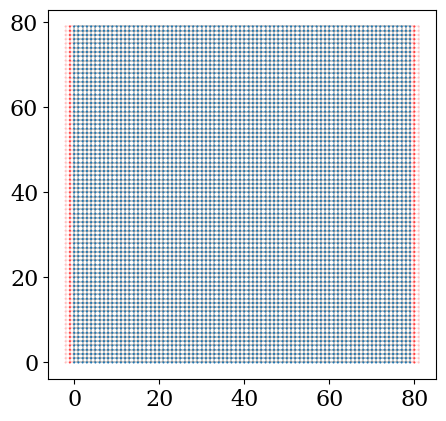

Text(0, 0.5, '$U_{\\rm img}/(\\hbar\\omega_B)$')

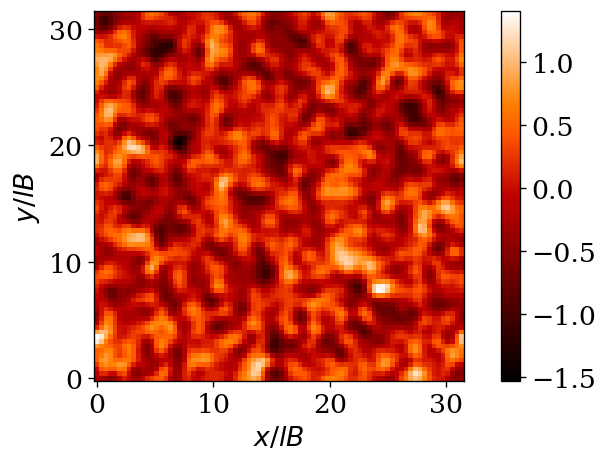

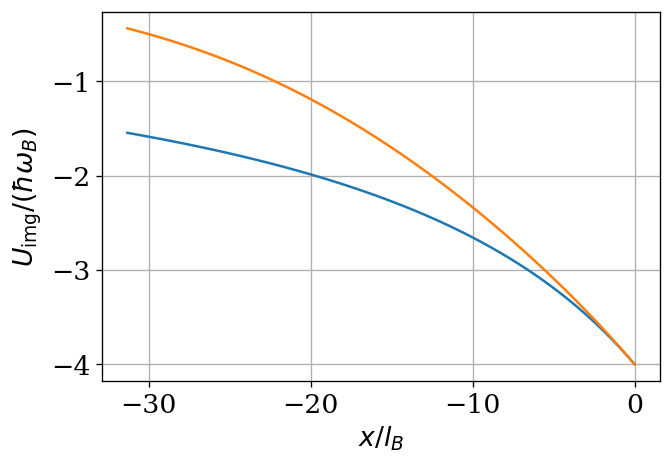

In [56]:
#plot some structural kwant stuff
kwant.plot(sys);

xvec = np.linspace(0, L-1, int(L) )
yvec = np.linspace(0, W-1, int(W) )
X, Y = np.meshgrid(xvec, yvec)

fig_W, ax_W = plt.subplots(dpi=120, figsize=(8, 4))
vmin = 0.
vmax = 1.000
Wmap_plot = ax_W.pcolormesh(X/lB, Y/lB, (Vdis.real), cmap='gist_heat', alpha=1)  #, vmin=vmin, vmax=vmax)
fig_W.colorbar(Wmap_plot)
ax_W.set_xlabel(r'$x/lB$')
ax_W.set_ylabel(r'$y/lB$')
ax_W.set_aspect('equal')


fig_Img, ax_Img = plt.subplots(dpi=120, figsize=(6, 4))
ax_Img.plot( -yvec/lB, E_img/omB*(Vimg0) )
ax_Img.plot( -yvec/lB, E_img/omB*(Vimg1) )
ax_Img.grid()

ax_Img.set_xlabel(r'$x/l_B$')
ax_Img.set_ylabel(r'$U_{\rm img}/(\hbar\omega_B)$')
#ax_Img.set_aspect('equal')



In [57]:
ei = 0 * omB   #initial energy in cyclotrons
ef = 1.5 * omB   #final energy (lowest)
Ne = 200        #number of points for the conductance sweep

energies = np.linspace( ei, ef, Ne)  # Define a range of fermi energies to scan
G0 = np.zeros(Ne)
GIMG = np.zeros(Ne)
for ndis in range(iter_dis):
    Vdis = corr_dis(int(L), int(W), 1, xic)
    
    def G_conductance( E_dis, E_img, L, W, alpha, Vdis, Vimg, ne  ):
        energy = ei + (ef-ei)/Ne*ne
        params =SimpleNamespace( alpha=alpha, E_dis=E_dis, E_img=0, V=Vdis, Vimg=Vimg )
        params_img = SimpleNamespace( alpha=alpha, E_dis=E_dis, E_img=E_img, V=Vdis, Vimg=Vimg )

        smat = kwant.smatrix(sys, energy=energy, args=[params])
        smat_img = kwant.smatrix(sys, energy=energy, args=[params_img])
        G0_ne = smat.transmission(0, 1)
        GIMG_ne = smat_img.transmission(0, 1)
        return G0_ne, GIMG_ne


    # Define a function to compute conductance for a single iteration
    def compute_conductance(ne):
        return G_conductance( E_dis, E_img, L, W, alpha, Vdis, Vimg, ne  )

    # Use joblib to parallelize the loop
    results = Parallel(n_jobs=Ncore)(
        delayed(compute_conductance)(ne) for ne in range(Ne)
    )

    shotG0 = []
    shotGIMG = []
    # Aggregate the results
    for sG0, sGIMG in results:
        shotG0.append( sG0 )
        shotGIMG.append( sGIMG )

    shotG0 = np.asarray(shotG0)
    shotGIMG = np.asarray(shotGIMG)
    G0 += shotG0/iter_dis
    GIMG += shotGIMG/iter_dis

    

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_57829/3340030222.py:16: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_57829/3340030222.py:16: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_57829/3340030222.py:17: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_57829/3340030222.py:16: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_57829

In [58]:
# Define a threshold: small fraction of max(fX)
threshold_shift_IMGT = .0001
threshold_shift_0T = .0001

# Find the first index where fX exceeds the threshold
nonzero_indices_IMGT = np.where(GIMG > threshold_shift_IMGT)[0]
Eshift_IMG = energies[nonzero_indices_IMGT[0]]

# Find the first index where fX exceeds the threshold
nonzero_indices_0T = np.where(G0 > threshold_shift_0T)[0]
Eshift_0 = energies[nonzero_indices_0T[0]]

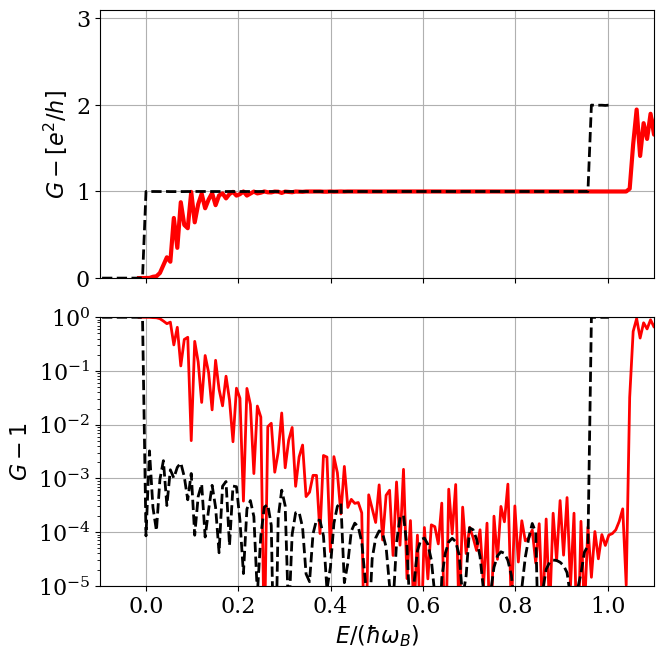

In [59]:
dG0_dE = np.gradient(G0, energies)
dGIMG_dE = np.gradient(GIMG, energies)
#Gamma_img = 2 * E_img
Gamma_img = 2*E_img/lB / ( (plate_distance/lB)**2 + 0*2*plate_distance/lB )
#print plateous
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# First subplot
ax1.plot( (energies-Eshift_IMG) / omB, GIMG, color='red', linewidth=3)
ax1.plot( (energies-Eshift_0) / omB, G0, color='black', linewidth=2, linestyle='--')

ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
ax1.set_xlim( ( np.amin(energies/ omB), np.amax(energies/ omB)) )

ax2.plot( (energies-Eshift_IMG) / omB, np.abs(GIMG-1), color='red', linewidth=2, linestyle='-')
ax2.plot( (energies-Eshift_0) / omB, np.abs(G0-1), color='black', linewidth=2, linestyle='--')


ax2.set_ylabel(r"$G-1$", fontdict=font)
ax2.set_xlabel(r"$E/(\hbar\omega_B)$", fontdict=font)

ax1.set_ylim((.0, 3.1))
ax1.set_xlim((-.1, 1.1))

ax2.set_ylim((1e-5, 1e0))  # Adjust the lower limit to avoid log(0) issues
ax2.set_xlim((-.1, 1.1))

ax2.set_yscale('log')  # Set log scale on y-axis

ax1.grid()
ax2.grid()
ax1.set_xticklabels([])

# Define shaded regions' x-intervals
om0 = -omB**2/32*(2*0**2+2*0+1)
om1 = omB-omB**2/32*(2*1**2+2*1+1)
om2 = omB*2-omB**2/32*(2*2**2+2*2+1)

"""shaded_regions = [(0,  Gamma_img / omB ), (1.0,  1.0+2**.5*Gamma_img / omB ), (2.02,  2.02+3**.5*Gamma_img / omB ), (3.03,  3.03+4**.5*Gamma_img / omB )]
# Loop to add shaded areas and vertical boundary lines
for x_start, x_end in shaded_regions:
    ax1.axvspan(x_start, x_end, color='yellow', alpha=0.3)  # Shaded area in ax1
    ax2.axvspan(x_start, x_end, color='yellow', alpha=0.3)  # Shaded area in ax2
    ax1.axvline(x_start, color='black', linewidth=1)  # Left boundary
    ax1.axvline(x_end, color='black', linewidth=1)  # Right boundary
    ax2.axvline(x_start, color='black', linewidth=1)  # Left boundary
    ax2.axvline(x_end, color='black', linewidth=1)  # Right boundary"""

plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)

plt.show()

In [60]:
# save platos in a file
import pandas as pd
#nG = 0
# Parameters
params = {
    "t": t,
    "W": W,
    "L": L,
    "alpha": alpha,
    "xic": xic,
    "plate_distance": plate_distance,
    "E_dis": E_dis,
    "E_img": E_img,
    "ei": ei,
    "ef": ef,
    "Ne": Ne,
    "iter_dis": iter_dis,
    "Ncore": Ncore
}

# Create a DataFrame
data = pd.DataFrame({
    'Energies': energies,
    'G0': G0,
    'GIMG': GIMG
})

# Write parameters and data to a file
filename = 'G_%d.dat' % (nG)
with open(filename, 'w') as f:
    # Write parameters as comments
    for key, value in params.items():
        f.write(f"# {key} = {value}\n")
    # Write the data
    data.to_csv(f, sep=' ', index=False, header=True)